# **1. Cek resource**

In [ ]:
import torch

if torch.cuda.is_available():
  device = torch.device('cuda')

  print('there are %d GPU(s) available.' % torch.cuda.device_count())

  print('we will use the GPU: ', torch.cuda.get_device_name(0))
  USE_CUDA = True
else:
  USE_CUDA = False
  print("No GPU available, using the CPU instead")
  device = torch.device("cpu")

there are 1 GPU(s) available.
we will use the GPU:  Tesla T4


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 93.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 116.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 85.1 MB/s eta 0:00:00


## Import library

In [ ]:
import pandas as pd

In [ ]:
import time
import datetime
from tqdm import tqdm

def format_time(elapsed):
  elapsed_rounded = int(round(elapsed))
  return str(datetime.timedelta(seconds=elapsed_rounded))

# Preparation

## Config

In [ ]:
RANDOM_SEED = 843734
max_seq = 128
l_rate = 2e-5   # or 5e-5
epochs = 20
batch_size = 16  # or 32
patience = 5
OUTPUT_DIM = 2 # Binary

main_path = "/content/gdrive/My Drive/TA/Ards/"

dataset_path = main_path + "datas/datasets_cleaned.csv"
graph_path =  main_path + "graph/"
report_path =  main_path + "report/"

bert_path = 'indobenchmark/indobert-base-p2'
model_name = "indobert_2e5_16"
model_save_name = F"{model_name}.pth"
model_identifier = "f_"
model_path = F"{main_path}saved/f_{model_save_name}"
tokenizer_path = F"{main_path}tokenizer/{model_name}"
best_model_path = F"{main_path}saved/b_{model_save_name}"

# Load Data

In [ ]:
df=pd.read_csv(dataset_path, encoding='latin-1')
df.head()

,ï»¿usefulness,userName,score,at,content
0,1,IYAN JM,1,1/5/2023 7:22,tidak bisa upload foto ktp maupun stnk baik la...
1,1,Abdul Gani,1,1/5/2023 5:58,pembayaran ovo tidak bisa saya sudah isi ovo s...
2,1,oplet,1,1/5/2023 3:25,sudah daftar tapi tidak bisa masuk
3,0,Yudi Novianto,3,1/5/2023 3:13,kalo di saya aplikasi ini tidak terlalu bermas...
4,0,holdi saputra,1,1/5/2023 0:18,aplikasi tidak ada guna nya kebanyakan tidak b...


In [ ]:
df = df.rename(columns={'content': 'text', 'ï»¿usefulness': 'label'})
df.head()

,label,userName,score,at,text
0,1,IYAN JM,1,1/5/2023 7:22,tidak bisa upload foto ktp maupun stnk baik la...
1,1,Abdul Gani,1,1/5/2023 5:58,pembayaran ovo tidak bisa saya sudah isi ovo s...
2,1,oplet,1,1/5/2023 3:25,sudah daftar tapi tidak bisa masuk
3,0,Yudi Novianto,3,1/5/2023 3:13,kalo di saya aplikasi ini tidak terlalu bermas...
4,0,holdi saputra,1,1/5/2023 0:18,aplikasi tidak ada guna nya kebanyakan tidak b...


In [ ]:
text = df['text']
labels = df['label']

In [ ]:
labels.value_counts()

1    5205
0    5205
Name: label, dtype: int64

# Tokenizing

In [ ]:
import torch

import random
import numpy as np

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [ ]:
# Set random seed
set_seed(RANDOM_SEED)

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained(bert_path)

In [ ]:
from tabulate import tabulate

In [ ]:
max_length = df['text'].apply(lambda x: len(tokenizer.encode(x))).max()
max_indices = df[df['text'].apply(lambda x: len(tokenizer.encode(x))) == max_length].index.tolist()

In [ ]:
max_length

110

In [ ]:
max_indices = max_indices[0]

In [ ]:
len(tokenizer.encode(df['text'][max_indices]))

110

In [ ]:
df['text'][max_indices]

'waktu itu kendalanya setiap foto selalu maaf itu bukan struk bbk padahal jelas itu struk dari pertamina itu sudah agak benar eh sekarang tiap upload pilih dari foto ada batas scan nya dann parahnya adalah ketika baru foto kali itu bilang maaf batas scan anda habis maksudnya bagaimana coba terus juga ada keluar memory ram hp anda tidak cukup lah hape gue biasa biasa saja tuh kak kenapa kenapa dipakai fb twitter ig dan wa biasa saja kenapa repot benar pakai pertamina kalau memang nge php mengapai dibuat beginian kan mengapai meminta struk ke mbak mbaknya di pom'

In [ ]:
def preprocessing(input_text, tokenizer):
  '''
  Returns <class transformers.tokenization_utils_base.BatchEncoding> with the following fields:
    - input_ids: list of token ids
    - token_type_ids: list of token type ids
    - attention_mask: list of indices (0,1) specifying which tokens should considered by the model (return_attention_mask = True).
  '''
  return tokenizer.encode_plus(input_text, add_special_tokens = True, max_length = max_seq,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt'
                   )

In [ ]:
type(text)

pandas.core.series.Series

In [ ]:
input_ids = []
attention_masks = []

for sample in tqdm(text.tolist()):
  encoding_dict = preprocessing(sample, tokenizer)
  input_ids.append(encoding_dict['input_ids'])
  attention_masks.append(encoding_dict['attention_mask'])

  0%|          | 0/10410 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 10410/10410 [00:08<00:00, 1173.02it/s]


In [ ]:
labels

0        1
1        1
2        1
3        0
4        0
        ..
10405    0
10406    0
10407    0
10408    0
10409    0
Name: label, Length: 10410, dtype: int64

In [ ]:
input_ids = torch.cat(input_ids, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
# labels = torch.tensor(labels)

In [ ]:
# print("Max token id length: ", max([len(sen) for sen in input_ids]))

In [ ]:
labels

0        1
1        1
2        1
3        0
4        0
        ..
10405    0
10406    0
10407    0
10408    0
10409    0
Name: label, Length: 10410, dtype: int64

### Observe some random tokenized data

In [ ]:
# train_input[max_indices]

In [ ]:
def print_rand_sentence_encoding():
  '''Displays tokens, token IDs and attention mask of a random text sample'''
  index = random.randint(0, len(text) - 1)
  tokens = tokenizer.tokenize(tokenizer.decode(input_ids[index]))
  sample_token_ids = [i.numpy() for i in input_ids[index]]
  attention = [i.numpy() for i in attention_masks[index]]

  table = np.array([tokens, sample_token_ids, attention]).T
  print(tabulate(table,
                 headers = ['Tokens', 'Token IDs', 'Attention Mask'],
                 tablefmt = 'fancy_grid'))
  print("Tokens       : ", tokens)
  print("Token IDs: ", input_ids[index])
  print("Attention Mask: ", attention_masks[index])

print_rand_sentence_encoding()

╒══════════╤═════════════╤══════════════════╕
│ Tokens   │   Token IDs │   Attention Mask │
╞══════════╪═════════════╪══════════════════╡
│ [CLS]    │           2 │                1 │
├──────────┼─────────────┼──────────────────┤
│ rakyat   │        1829 │                1 │
├──────────┼─────────────┼──────────────────┤
│ sudah    │         259 │                1 │
├──────────┼─────────────┼──────────────────┤
│ susah    │        3684 │                1 │
├──────────┼─────────────┼──────────────────┤
│ tambah   │        3837 │                1 │
├──────────┼─────────────┼──────────────────┤
│ di       │          26 │                1 │
├──────────┼─────────────┼──────────────────┤
│ bikin    │        2999 │                1 │
├──────────┼─────────────┼──────────────────┤
│ susah    │        3684 │                1 │
├──────────┼─────────────┼──────────────────┤
│ [SEP]    │           3 │                1 │
├──────────┼─────────────┼──────────────────┤
│ [PAD]    │           0 │        

# Split data

In [ ]:
from sklearn.model_selection import train_test_split


# Split data into 90% train and 10% test
train_input_1, test_input, train_labels_1, test_labels = train_test_split(input_ids,
                                                                      labels,
                                                                      random_state=RANDOM_SEED,
                                                                      test_size=0.1,
                                                                      stratify=labels)
#
train_mask, test_mask, _, _ = train_test_split(attention_masks,
                                               labels,
                                               random_state=RANDOM_SEED,
                                               test_size=0.1,
                                               stratify=labels)

# Split remaining 90% train data into 70% train and 20% validation
train_input, validation_input, train_labels, validation_labels = train_test_split(train_input_1,
                                                                                  train_labels_1,
                                                                                  random_state=RANDOM_SEED,
                                                                                  test_size=0.222,
                                                                                  stratify=train_labels_1)
train_mask, validation_mask, _, _ = train_test_split(train_mask,
                                                     train_labels_1,
                                                     random_state=RANDOM_SEED,
                                                     test_size=0.222,
                                                     stratify=train_labels_1)


In [ ]:
original_test_labels = test_labels
original_test_labels

6508     0
3239     0
1542     1
8122     0
6454     0
        ..
6857     0
8466     0
10330    0
7587     0
2155     1
Name: label, Length: 1041, dtype: int64

In [ ]:
original_val_labels = validation_labels
original_val_labels

9019    1
3931    1
3399    0
9154    1
2934    0
       ..
8483    0
1171    1
9940    0
5435    0
2613    0
Name: label, Length: 2080, dtype: int64

In [ ]:
train_labels = train_labels.values.tolist()
validation_labels = validation_labels.values.tolist()
test_labels = test_labels.values.tolist()

In [ ]:
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
test_labels = torch.tensor(test_labels)

In [ ]:
import numpy as np
print("== Train ==")
print("Input: ", train_input.shape)
print("Label: ", train_labels.shape)
print("Mask: ", np.array(train_mask).shape)

print("\n== Validation ==")
print("Input: ", validation_input.shape)
print("Label: ", validation_labels.shape)
print("Mask: ", np.array(validation_mask).shape)

print("\n== Test ==")
print("Input: ", test_input.shape)
print("Label: ", test_labels.shape)
print("Mask: ", np.array(test_mask).shape)

== Train ==
Input:  torch.Size([7289, 128])
Label:  torch.Size([7289])
Mask:  (7289, 128)

== Validation ==
Input:  torch.Size([2080, 128])
Label:  torch.Size([2080])
Mask:  (2080, 128)

== Test ==
Input:  torch.Size([1041, 128])
Label:  torch.Size([1041])
Mask:  (1041, 128)


In [ ]:
unique_train_labels, counts_train_labels = torch.unique(train_labels, return_counts=True)
unique_validation_labels, counts_validation_labels = torch.unique(validation_labels, return_counts=True)
unique_test_labels, counts_test_labels = torch.unique(test_labels, return_counts=True)

print("train_labels", unique_train_labels)  # tensor([0, 1])
print(counts_train_labels)
print("validation_labels", unique_validation_labels)  # tensor([0, 1])
print(counts_validation_labels)
print("train_labels", unique_test_labels)  # tensor([0, 1])
print(counts_test_labels)

train_labels tensor([0, 1])
tensor([3645, 3644])
validation_labels tensor([0, 1])
tensor([1040, 1040])
train_labels tensor([0, 1])
tensor([520, 521])


Ubah ke dataloader

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

train_data = TensorDataset(train_input, train_mask, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_input, validation_mask, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

test_data = TensorDataset(test_input, test_mask, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# Prepare Model

## Model Class

In [ ]:
import torch.nn as nn
from transformers import PreTrainedModel, BertConfig

In [ ]:
class IndoBERTModel(PreTrainedModel):
    config_class = BertConfig
    def __init__(self, bert_config, bert_pretrained, num_classes):
        super().__init__(bert_config)
        self.bert = bert_pretrained
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.fc(pooled_output)
        return logits

In [ ]:
from transformers import BertModel, AdamW, BertConfig, BertForSequenceClassification

bert = BertModel.from_pretrained(bert_path)

# Create the default BERT config
bert_config = BertConfig()

## new instance

In [ ]:
model = IndoBERTModel(
    bert_config,
    bert,
    OUTPUT_DIM
)
model.cuda()

IndoBERTModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

In [ ]:
# model = BertForSequenceClassification.from_pretrained(
#     bert_path, # Use the 12-layer BERT model, with an cased vocab.
#     num_labels = 2,
#     output_attentions = False, # return attentions weights
#     output_hidden_states = False, # returns all hidden-states
#     ignore_mismatched_sizes=True
# )

# model.cuda()

## Loss and Optimizer

In [ ]:
# define loss function
criterion = nn.BCEWithLogitsLoss()
# criterion = nn.CrossEntropyLoss()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=l_rate)
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 2e-05
    maximize: False
    weight_decay: 0
)


# Train

## Checkpoint

In [ ]:
class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's
    metrics is better than the previous, then save the
    model state.
    """
    def __init__(
        self, mode='min'
    ):
        self.mode= mode
        if mode == 'max':
          self.best_metrics = 0.0
        elif mode == 'min':
          self.best_metrics = float('inf')

    def __call__(
        self, metrics,
        epoch, model, optimizer, criterion
    ):
        if self.mode == 'max':
          if metrics > self.best_metrics:
            print(f"\nValidation Accuracy improved from {self.best_metrics} to {metrics}")
            self.best_metrics = metrics
            print(f"Saving best model for epoch: {epoch}")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict()
                }, best_model_path)
            return True
          else :
            print("\nCurrent Val_Acc: ",metrics)
            print(f"validation accuracy did not improve from: {self.best_metrics}")
            return False
        elif self.mode == 'min':
          if metrics < self.best_metrics:
            print(f"\nValidation loss is improved from {self.best_metrics} to {metrics}")
            self.best_metrics = metrics
            print(f"Saving best model for epoch: {epoch}\n")
            torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict()
                }, best_model_path)
            return True
          else :
            print("\nCurrent Val_Loss: ", metrics)
            print(f"validation loss did not improve from: {self.best_metrics}")
            return False

In [ ]:
def save_model(epochs, model, optimizer, criterion):
    """
    Function to save the trained model to disk.
    """
    print(f"Saving final model...")
    # parameters, gradParameters = model.parameters()
    # lightModel = model.clone('weight','bias','running_mean','running_std')

    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict()
                }, model_path)

## Early Stopper

In [ ]:
class EarlyStopping(object):
    def __init__(self, mode='min', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)


        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False


    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False


        if np.isnan(metrics):
            return True


        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1


        if self.num_bad_epochs >= self.patience:
            print('terminating because of early stopping!')
            return True


        return False


    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)


## Define function

In [ ]:
import torch.nn.functional as F
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

In [ ]:
def train(model, epoch):

  print('\nEpoch : %d'%epoch)

  model.train()
  torch.set_grad_enabled(True)

  t0 = time.time()
  num_correct, total_samples, total_train_loss =  0, 0, 0
  list_pred, list_label = [], []

  train_pbar = tqdm(train_dataloader, leave=True, total=len(train_dataloader))
  for i, batch_data in enumerate(train_pbar):

      b_input_ids = batch_data[0].to(device)
      b_input_mask = batch_data[1].to(device)
      b_labels = batch_data[2].to(device)

      model.zero_grad()

      outputs = model(b_input_ids,
                      b_input_mask)

      # calculate loss
      b_labels = F.one_hot(b_labels, num_classes = OUTPUT_DIM).float()

      loss = criterion(outputs, b_labels)

      # Update model
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Calculate
      predictions = torch.argmax(outputs, dim=1)
      list_pred.extend(predictions.cpu().numpy().tolist())
      list_label += torch.argmax(b_labels, dim=1).int().tolist()
      total_train_loss += loss.item()
      num_correct += (predictions == torch.argmax(b_labels, dim=1)).sum().item()
      total_samples += len(b_labels)

      del b_input_ids, b_input_mask, b_labels, outputs  # free up memory
      train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} ACC:{:.4f} LR:{:.8f}".format((epoch),
          total_train_loss / (i+1), num_correct / total_samples, get_lr(optimizer)))

  # calculate training accuracy and average training loss
  accu = num_correct / len(train_dataloader.dataset)
  avg_train_loss = total_train_loss / len(train_dataloader)

  learning_rate = get_lr(optimizer)
  elapsed = format_time(time.time() - t0)

  print('Train Loss: %.3f | Accuracy: %.3f | LR: %.3f'%(avg_train_loss,accu,learning_rate))
  print("Train Elapsed: {:}".format(elapsed))

  return accu, avg_train_loss, elapsed

In [ ]:
def eval(model, epoch):

  model.eval()
  torch.set_grad_enabled(False)

  total_loss, total_correct, total_samples = 0, 0, 0
  list_pred, list_label = [], []

  pbar = tqdm(validation_dataloader, leave=True, total=len(validation_dataloader))
  for i, batch_data in enumerate(pbar):

      b_input_ids = batch_data[0].to(device)
      b_input_mask = batch_data[1].to(device)
      b_labels = batch_data[2].to(device)

      outputs = model(b_input_ids,
                      b_input_mask)

      b_labels = F.one_hot(b_labels, num_classes = OUTPUT_DIM).float()
      loss = criterion(outputs, b_labels)

      # Calculate total loss
      valid_loss = loss.item()
      total_loss += valid_loss

      # Calculate evaluation metrics
      predictions = torch.argmax(outputs, dim=1)
      list_pred.extend(predictions.cpu().numpy().tolist())
      list_label += torch.argmax(b_labels, dim=1).int().tolist()

      total_correct += (predictions == torch.argmax(b_labels, dim=1)).sum().item()
      total_samples += len(b_labels)

      del b_input_ids, b_input_mask, b_labels, outputs  # free up memory
      pbar.set_description("VALID LOSS:{:.4f}  ACC:{:.4f} ".format(total_loss/(i+1), total_correct / total_samples))

  list_y_pred = np.array(list_pred)

  eval_loss = total_loss/(i+1)
  accu = total_correct / total_samples

  print('VALID LOSS: %.4f | Accuracy: %.4f'%(eval_loss,accu))

  return accu, eval_loss, list_y_pred

In [ ]:
def test(model, test_loader):
    list_y_pred = []
    list_y_prob = []
    list_y_label = []

    model.eval()
    t0 = time.time()
    num_correct, total_samples, test_loss =  0, 0, 0

    pbar = tqdm(test_loader, leave=True, total=len(test_loader))
    for i, batch_data in enumerate(pbar):

        b_input_ids = batch_data[0].to(device)
        b_input_mask = batch_data[1].to(device)
        b_labels = batch_data[2].to(device)

        outputs = model(b_input_ids,
                      b_input_mask)

        b_labels = F.one_hot(b_labels, num_classes=2).float()

        loss = criterion(outputs, b_labels)

        predictions = torch.argmax(outputs, dim=1)
        proba = torch.softmax(outputs, dim=1)[:, 1]

        list_y_pred.extend(predictions.cpu().numpy().tolist())
        list_y_prob.extend(proba.detach().cpu().numpy().tolist())
        list_y_label += torch.argmax(b_labels, dim=1).int().tolist()

        test_loss += loss.item()
        num_correct += (predictions == torch.argmax(b_labels, dim=1)).sum().item()
        total_samples += len(b_labels)


        del b_input_ids, b_input_mask, b_labels, outputs  # free up memory
        pbar.set_description("Test LOSS:{:.4f}  ACC:{:.4f} ".format(test_loss/(i+1), num_correct / total_samples))
    test_loss = test_loss/(i+1)
    test_acc = num_correct / total_samples

    list_y_pred = np.array(list_y_pred)
    list_y_prob = np.array(list_y_prob)
    list_y_label = np.array(list_y_label)

    auc_score = roc_auc_score(list_y_label, list_y_prob)

    elapsed = format_time(time.time() - t0)
    print('Elapsed :', elapsed)
    return test_loss, test_acc, auc_score, list_y_pred, list_y_prob, list_y_label

## Train and validate

In [ ]:
history = {
    'epoch': [],
    'loss': [],
    'accuracy': [],
    'val_loss': [],
    'val_accuracy': [],
    'time': [],
    'time_val': [],
    'save': [],
    }
val_y_pred = []

n_epochs = epochs
time0 = time.time()
save_best_model = SaveBestModel(mode='max')
es = EarlyStopping(patience=patience, mode='max') # min : lower is better metric | max kebalikannya
for epoch in range(1,n_epochs+1):
  history['epoch'].append(epoch)
  i_time = time.time()
  train_accuracy, train_loss, tr_elapsed = train(model, epoch)

  history['accuracy'].append(train_accuracy)
  history['loss'].append(train_loss)
  history['time'].append(tr_elapsed)

  val_accu, val_loss, eval_y_pred = eval(model, epoch)

  history['val_accuracy'].append(val_accu)
  history['val_loss'].append(val_loss)

  i_elapsed = format_time(time.time() - i_time)
  history['time_val'].append(i_elapsed)

  is_save = save_best_model(
      val_accu, epoch, model, optimizer, criterion
      )
  history['save'].append(is_save)

  if es.step(val_accu):
    print("Early Stopping")
    break

elapsed = format_time(time.time() - time0)
print('TOTAL TRAIN ELAPSED ', elapsed)


Epoch : 1


(Epoch 1) TRAIN LOSS:0.2036 ACC:0.9170 LR:0.00002000: 100%|██████████| 456/456 [02:41<00:00,  2.82it/s]


Train Loss: 0.204 | Accuracy: 0.917 | LR: 0.000
Train Elapsed: 0:02:42


VALID LOSS:0.1354  ACC:0.9476 : 100%|██████████| 130/130 [00:15<00:00,  8.25it/s]


VALID LOSS: 0.1354 | Accuracy: 0.9476

Validation Accuracy improved from 0.0 to 0.9475961538461538
Saving best model for epoch: 1

Epoch : 2


(Epoch 2) TRAIN LOSS:0.0871 ACC:0.9701 LR:0.00002000: 100%|██████████| 456/456 [02:40<00:00,  2.84it/s]


Train Loss: 0.087 | Accuracy: 0.970 | LR: 0.000
Train Elapsed: 0:02:41


VALID LOSS:0.1366  ACC:0.9529 : 100%|██████████| 130/130 [00:15<00:00,  8.32it/s]


VALID LOSS: 0.1366 | Accuracy: 0.9529

Validation Accuracy improved from 0.9475961538461538 to 0.9528846153846153
Saving best model for epoch: 2

Epoch : 3


(Epoch 3) TRAIN LOSS:0.0504 ACC:0.9829 LR:0.00002000: 100%|██████████| 456/456 [02:40<00:00,  2.84it/s]


Train Loss: 0.050 | Accuracy: 0.983 | LR: 0.000
Train Elapsed: 0:02:41


VALID LOSS:0.1422  ACC:0.9524 : 100%|██████████| 130/130 [00:15<00:00,  8.27it/s]


VALID LOSS: 0.1422 | Accuracy: 0.9524

Current Val_Acc:  0.9524038461538461
validation accuracy did not improve from: 0.9528846153846153

Epoch : 4


(Epoch 4) TRAIN LOSS:0.0237 ACC:0.9918 LR:0.00002000: 100%|██████████| 456/456 [02:40<00:00,  2.84it/s]


Train Loss: 0.024 | Accuracy: 0.992 | LR: 0.000
Train Elapsed: 0:02:40


VALID LOSS:0.1804  ACC:0.9452 : 100%|██████████| 130/130 [00:15<00:00,  8.27it/s]


VALID LOSS: 0.1804 | Accuracy: 0.9452

Current Val_Acc:  0.9451923076923077
validation accuracy did not improve from: 0.9528846153846153

Epoch : 5


(Epoch 5) TRAIN LOSS:0.0184 ACC:0.9942 LR:0.00002000: 100%|██████████| 456/456 [02:40<00:00,  2.84it/s]


Train Loss: 0.018 | Accuracy: 0.994 | LR: 0.000
Train Elapsed: 0:02:41


VALID LOSS:0.1837  ACC:0.9534 : 100%|██████████| 130/130 [00:15<00:00,  8.28it/s]


VALID LOSS: 0.1837 | Accuracy: 0.9534

Validation Accuracy improved from 0.9528846153846153 to 0.9533653846153847
Saving best model for epoch: 5
TOTAL TRAIN ELAPSED  0:14:49


In [ ]:
history

{'epoch': [1, 2, 3, 4, 5],
 'loss': [0.20363059075418533,
  0.08712322876498658,
  0.0504028931680838,
  0.023693009180102597,
  0.0184412110305091],
 'accuracy': [0.9169982164906023,
  0.970091919330498,
  0.9828508711757443,
  0.9917684181643572,
  0.99423789271505],
 'val_loss': [0.1354362880381254,
  0.13664106452980868,
  0.14224428051652815,
  0.18042749608016143,
  0.18372245801326173],
 'val_accuracy': [0.9475961538461538,
  0.9528846153846153,
  0.9524038461538461,
  0.9451923076923077,
  0.9533653846153847],
 'time': ['0:02:42', '0:02:41', '0:02:41', '0:02:40', '0:02:41'],
 'time_val': ['0:02:57', '0:02:56', '0:02:56', '0:02:56', '0:02:56'],
 'save': [True, True, False, False, True]}

In [ ]:
df_report = pd.DataFrame(history)

# Define the output file name
output_report_file = report_path + model_save_name + ' train report.csv'

# Write the DataFrame to a CSV file
df_report.to_csv(output_report_file, index=False)

In [ ]:
epoch

5

In [ ]:
import matplotlib.pyplot as plt


## plot train & validation loss

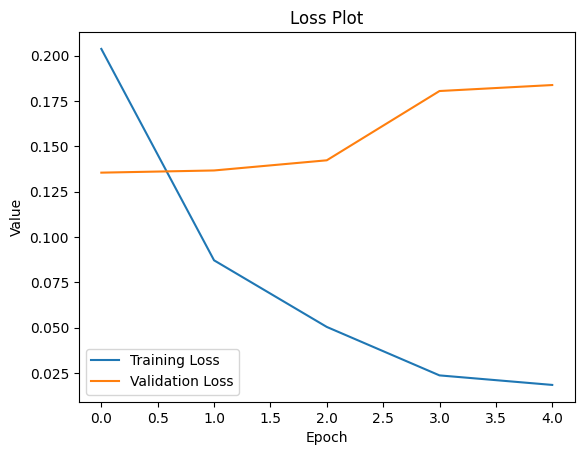

In [ ]:
plt.figure(1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="best")
plt.savefig(graph_path+ model_save_name + ' Train & Validation Loss.png',dpi=300,bbox_inches='tight')

## plot train & validation accuracy

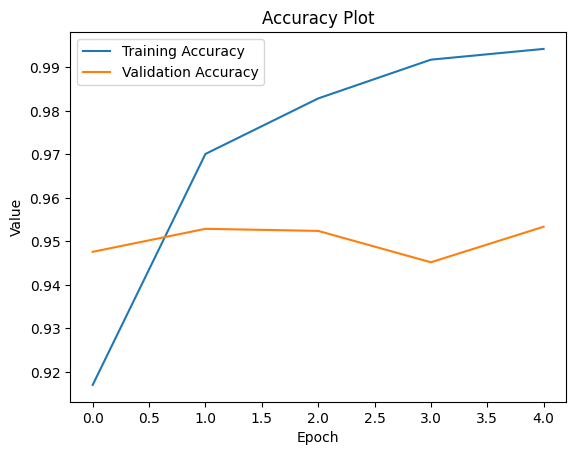

In [ ]:
plt.figure(2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="best")
plt.savefig(graph_path+ model_save_name + ' Train & Validation Accuracy.png',dpi=300,bbox_inches='tight')

In [ ]:
history['accuracy']

[0.9169982164906023,
 0.970091919330498,
 0.9828508711757443,
 0.9917684181643572,
 0.99423789271505]

In [ ]:
history['val_accuracy']

[0.9475961538461538,
 0.9528846153846153,
 0.9524038461538461,
 0.9451923076923077,
 0.9533653846153847]

In [ ]:
history['loss']

[0.20363059075418533,
 0.08712322876498658,
 0.0504028931680838,
 0.023693009180102597,
 0.0184412110305091]

In [ ]:
history['val_loss']

[0.1354362880381254,
 0.13664106452980868,
 0.14224428051652815,
 0.18042749608016143,
 0.18372245801326173]

## Evaluate on test

In [ ]:
test_loss, test_acc, test_auc_score, list_y_pred, list_y_prob, list_y_true = test(model, test_dataloader)

Test LOSS:0.2217  ACC:0.9462 : 100%|██████████| 66/66 [00:07<00:00,  8.46it/s]

Elapsed : 0:00:08


In [ ]:
list_y_pred

array([0, 0, 1, ..., 0, 0, 1])

In [ ]:
list_y_true

array([0, 0, 1, ..., 0, 0, 1])

# Ukur

In [ ]:
import sklearn

from sklearn.metrics import confusion_matrix, matthews_corrcoef

In [ ]:
label_map = {  0: 'Normal', 1: 'Harras'}
# list_y_pred = np.array([label_map[y] for y in list_y_pred])
# list_y_true = np.array([label_map[y] for y in list_y_true])

# print("list_y_pred", len(list_y_pred))

# print("list_y_pred", list_y_pred)

cf_matrix = confusion_matrix(list_y_true, list_y_pred)

In [ ]:
cf_matrix

array([[480,  40],
       [ 16, 505]])

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

<Figure size 640x480 with 0 Axes>

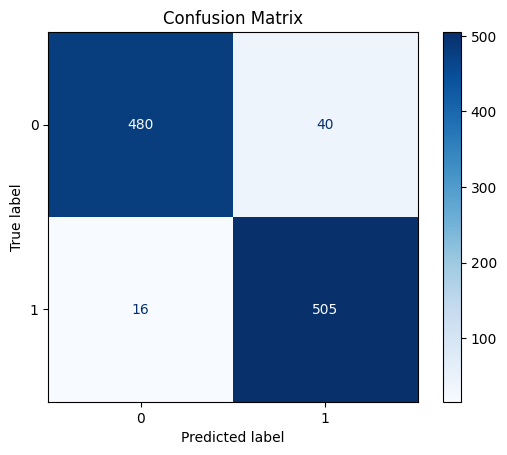

In [ ]:
plt.figure(3)
cf_matrix = ConfusionMatrixDisplay.from_predictions(list_y_true, list_y_pred, cmap='Blues')
plt.title('Confusion Matrix')
plt.savefig(graph_path+ model_identifier + model_save_name + ' Confusion Matrix.png',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
precision, recall, f1_score, support = precision_recall_fscore_support(list_y_pred, list_y_true)
mcc_score = matthews_corrcoef(list_y_true, list_y_pred)

print("Accuracy: %.3f" % test_acc)
print("AUC: %.4f" % test_auc_score)
print("MCC: %.4f" % mcc_score)
print("Loss: %.3f" % test_loss)
print("Precision: %.3f " % np.mean(precision))
print("Recall: %.3f " % np.mean(recall))
print("F1-Score: %.3f " % np.mean(f1_score))

Accuracy: 0.946
AUC: 0.9845
MCC: 0.8934
Loss: 0.222
Precision: 0.946 
Recall: 0.947 
F1-Score: 0.946 


In [ ]:
test_report = {
    'test_accuracy': test_acc,
    'test_auc_score': test_auc_score,
    'test_mcc_score': mcc_score,
    'test_loss': test_loss,
    'test_precision': np.mean(precision),
    'test_recall': np.mean(recall),
    'test_f1_score': np.mean(f1_score)
    }

In [ ]:
df_report = pd.DataFrame(test_report, index=[0])

# Define the output file name
output_report_file = report_path + model_identifier + model_save_name + ' testing report.csv'

# Write the DataFrame to a CSV file
df_report.to_csv(output_report_file, index=False)

In [ ]:
# print the wrong predicted label

# Create a DataFrame to store the results
df = pd.DataFrame(columns=["Index", "Sentence", "True Label", "Predicted Label"])

i=0
for index, value in enumerate(list_y_true):
  if value != list_y_pred[i]:
    true_label = value
    predicted_label = list_y_pred[i]
    sentence = text[index]
    df = df.append({"Index": index, "Sentence": sentence, "True Label": true_label, "Predicted Label": predicted_label},
                       ignore_index=True)
    print('True Label:', true_label, '|', 'Predicted Label:', predicted_label)
    print('index:', index)
    print('Sentence:', sentence, '\n')
  i=i+1

# Define the output file name
output_report_file = report_path + model_identifier + model_save_name + ' wrong predictions report.csv'

# Write the DataFrame to a CSV file
df.to_csv(output_report_file, index=False)

True Label: 0 | Predicted Label: 1
index: 3
Sentence: kalo di saya aplikasi ini tidak terlalu bermasalah dan bisa digunakan setiap pengisian bahan bakar tetapi yang jadi masalahnya tempat pengisian pom bensinnya banyak yang tidak menyediakan pengisian non tunai cuma ada tempat yang melayani non tunai dan itupun keseringan mengalami gangguan jaringannya menurut versi karyawannya jadi aplikasi ini tidak bisa dipakai balik lagi ke tunai 

True Label: 0 | Predicted Label: 1
index: 29
Sentence: saya sudah daftar tapi biru nya enggak ada 

True Label: 0 | Predicted Label: 1
index: 66
Sentence: ini kenapa ya kabanyakan pom bensin belum tersedia layanan pertamanya yang alasanya jaringan error mesinya rusak apa jangan operatornya tidak bisa karena belum di training tolong dong yang seperti ini segera di perbaiki kita sebagai pengguna pertamanya yang mengikuti aturan perusahaan jadinya mengolok bayar bensin pakai uang pribadi kita kerja cari uang bukan menyambung untuk perusahaan atas perhatian 

<ipython-input-78-9d49492ef56a>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Index": index, "Sentence": sentence, "True Label": true_label, "Predicted Label": predicted_label},
<ipython-input-78-9d49492ef56a>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Index": index, "Sentence": sentence, "True Label": true_label, "Predicted Label": predicted_label},
<ipython-input-78-9d49492ef56a>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Index": index, "Sentence": sentence, "True Label": true_label, "Predicted Label": predicted_label},
<ipython-input-78-9d49492ef56a>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

True Label: 0 | Predicted Label: 1
index: 315
Sentence: aplikasi enggak jelas mau upgrade ktp maaf server sedang bermasalah mau scan struk tidak bisa juga padahal saya pakai wifi data sama saja tidak ada gurunya buka yang lain lancar saja hahaha kasih bintang saja kalo buat yang ini mah 

True Label: 0 | Predicted Label: 1
index: 316
Sentence: sudah di download mau buka aplikasinya saja enggak bisa malah tertulis jaringan tidak aman terus saya harus ganti jaringan apa 

True Label: 0 | Predicted Label: 1
index: 320
Sentence: kalo enggak niat mengasih hadiah jangan php ini orang 

True Label: 0 | Predicted Label: 1
index: 356
Sentence: ku pakai hp samsung yang enggak ada kamera depanya kok enggak bisa sudah akun force close melulu 

True Label: 0 | Predicted Label: 1
index: 365
Sentence: sudah bagi-bagi sih tapi kenapa saya tidak bisa upgrade member ya 

True Label: 1 | Predicted Label: 0
index: 368
Sentence: kok enggak bisa login 

True Label: 0 | Predicted Label: 1
index: 429
Sentence

<ipython-input-78-9d49492ef56a>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Index": index, "Sentence": sentence, "True Label": true_label, "Predicted Label": predicted_label},
<ipython-input-78-9d49492ef56a>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Index": index, "Sentence": sentence, "True Label": true_label, "Predicted Label": predicted_label},
<ipython-input-78-9d49492ef56a>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Index": index, "Sentence": sentence, "True Label": true_label, "Predicted Label": predicted_label},
<ipython-input-78-9d49492ef56a>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

 0 | Predicted Label: 1
index: 1019
Sentence: baru isi data pas daftar eee tulisannya terjadi kesalahan mulu kalau memang diharuskan pakai aplikasi mbok ya dibereskan dulu bug seperti itu itu kok ya ngoyo men keren 

True Label: 0 | Predicted Label: 1
index: 1036
Sentence: hp saya ram internal tapi selalu force close terus indak bisa dibuka versi ini kayaknya indak semua hp support masih nge bugs 



<ipython-input-78-9d49492ef56a>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Index": index, "Sentence": sentence, "True Label": true_label, "Predicted Label": predicted_label},


# Save and Load Model

## Save tokenizer

In [ ]:
tokenizer.save_pretrained(tokenizer_path)

('/content/gdrive/My Drive/TA/Ards/tokenizer/indobert_2e5_32-chng8/tokenizer_config.json',
 '/content/gdrive/My Drive/TA/Ards/tokenizer/indobert_2e5_32-chng8/special_tokens_map.json',
 '/content/gdrive/My Drive/TA/Ards/tokenizer/indobert_2e5_32-chng8/vocab.txt',
 '/content/gdrive/My Drive/TA/Ards/tokenizer/indobert_2e5_32-chng8/added_tokens.json')

## Save last model

In [ ]:
# save the trained model weights for a final time
save_model(epoch, model, optimizer, criterion)

Saving final model...


In [ ]:
import os.path

sz = os.path.getsize(model_path)
print(f'The {model_path} size is', sz, 'bytes')

The /content/gdrive/My Drive/TA/Ards/saved/f_indobert_2e5_32-chng8.pth size is 497860525 bytes


In [ ]:
# model = torch.load(model_path)
# model.cuda()

## Load Best model

In [ ]:
# load the best model checkpoint
best_model_cp = torch.load(best_model_path)
best_model_epoch = best_model_cp['epoch']
print(f"Best model was saved at {best_model_epoch} epochs\n")

Best model was saved at 2 epochs



In [ ]:
del model

In [ ]:
model_identifier = "b_"

In [ ]:
model = IndoBERTModel(
              bert_config,
              bert,
              OUTPUT_DIM)

In [ ]:
model.load_state_dict(best_model_cp['model_state_dict'])
model.cuda()

IndoBERTModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

## Load last model

In [ ]:
# load the last model checkpoint
last_model_cp = torch.load(model_path)
last_model_epoch = last_model_cp['epoch']
print(f"Last model was saved at {last_model_epoch} epochs\n")

Last model was saved at 14 epochs



In [ ]:
del model

In [ ]:
model_identifier = "f_"

In [ ]:
model = IndoBERTModel(
              bert_config,
              bert,
              OUTPUT_DIM)

In [ ]:

model.load_state_dict(last_model_cp['model_state_dict'])
model.cuda()


IndoBERTModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

## Testing

In [ ]:
test(model, test_dataloader)

Test LOSS:0.2765  ACC:0.9366 : 100%|██████████| 33/33 [00:07<00:00,  4.43it/s]

Elapsed : 0:00:07


(0.276527805096879,
 0.9365994236311239,
 0.9847445740439983,
 array([0, 1, 1, ..., 1, 1, 1]),
 array([6.25719636e-08, 9.99999762e-01, 9.99999881e-01, ...,
        9.99999881e-01, 9.99999881e-01, 9.32269871e-01]),
 array([0, 1, 1, ..., 1, 1, 1]))

#New space

## Evaluate on test

In [ ]:
test_loss, test_acc, test_auc_score, list_y_pred, list_y_prob, list_y_true = test(model, test_dataloader)

Test LOSS:0.1497  ACC:0.9424 : 100%|██████████| 66/66 [00:07<00:00,  8.73it/s]

Elapsed : 0:00:08


In [ ]:
list_y_prob

array([2.71644403e-05, 3.89332308e-06, 9.99985576e-01, ...,
       5.29385670e-06, 3.75531567e-06, 9.99983907e-01])

## Ukur

In [ ]:
import sklearn

from sklearn.metrics import confusion_matrix, matthews_corrcoef

In [ ]:
label_map = {  0: 'Normal', 1: 'Harras'}
# list_y_pred = np.array([label_map[y] for y in list_y_pred])
# list_y_true = np.array([label_map[y] for y in list_y_true])

# print("list_y_pred", len(list_y_pred))

# print("list_y_pred", list_y_pred)

cf_matrix = confusion_matrix(list_y_true, list_y_pred)

In [ ]:
cf_matrix

array([[490,  30],
       [ 17, 504]])

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

<Figure size 640x480 with 0 Axes>

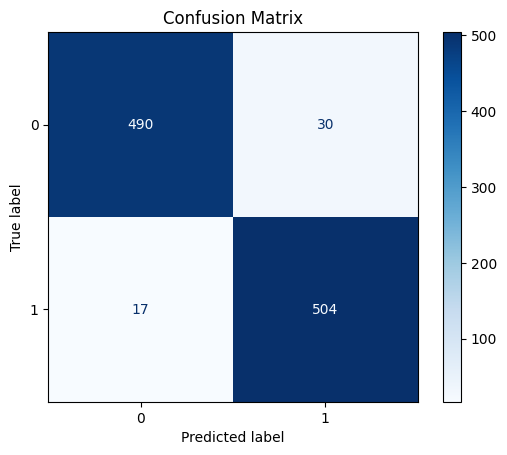

In [ ]:
plt.figure(3)
cf_matrix = ConfusionMatrixDisplay.from_predictions(list_y_true, list_y_pred, cmap='Blues')
plt.title('Confusion Matrix')
plt.savefig(graph_path+ model_identifier + model_save_name + ' Confusion Matrix.png',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
precision, recall, f1_score, support = precision_recall_fscore_support(list_y_pred, list_y_true)
mcc_score = matthews_corrcoef(list_y_true, list_y_pred)

print("Accuracy: %.5f" % test_acc)
print("AUC: %.4f" % test_auc_score)
print("MCC: %.4f" % mcc_score)
print("Loss: %.4f" % test_loss)
print("Precision: %.4f " % np.mean(precision))
print("Recall: %.4f " % np.mean(recall))
print("F1-Score: %.4f " % np.mean(f1_score))

Accuracy: 0.95485
AUC: 0.9921
MCC: 0.9100
Loss: 0.1211
Precision: 0.9548 
Recall: 0.9551 
F1-Score: 0.9548 


In [ ]:
test_report = {
    'test_accuracy': test_acc,
    'test_auc_score': test_auc_score,
    'test_mcc_score': mcc_score,
    'test_loss': test_loss,
    'test_precision': np.mean(precision),
    'test_recall': np.mean(recall),
    'test_f1_score': np.mean(f1_score)
    }

In [ ]:
df_report = pd.DataFrame(test_report, index=[0])

# Define the output file name
output_report_file = report_path + model_identifier + model_save_name + ' testing report.csv'

# Write the DataFrame to a CSV file
df_report.to_csv(output_report_file, index=False)

In [ ]:
# print the wrong predicted label

# Create a DataFrame to store the results
df = pd.DataFrame(columns=["Index", "Sentence", "True Label", "Predicted Label"])

i=0
for index, value in original_test_labels.iteritems():
  if value != list_y_pred[i]:
    true_label = value
    predicted_label = list_y_pred[i]
    sentence = text[index]
    df = df.append({"Index": index, "Sentence": sentence, "True Label": true_label, "Predicted Label": predicted_label},
                       ignore_index=True)
    print('True Label:', true_label, '|', 'Predicted Label:', predicted_label)
    print('index:', index)
    print('Sentence:', sentence, '\n')
  i=i+1

# Define the output file name
output_report_file = report_path + model_identifier + model_save_name + ' wrong predictions report.csv'

# Write the DataFrame to a CSV file
df.to_csv(output_report_file, index=False)

True Label: 0 | Predicted Label: 1
index: 5911
Sentence: setelah update sering ge lag mungkin kalau skala kecil masih bagus ini mau dipakai oleh masyarakat indonesia harusnya dibuat sistem lebih bagus 

True Label: 1 | Predicted Label: 0
index: 5786
Sentence: sinyal nya bagus tapi aplikasi nya malah bisa dibuka dengan lancar saya tidak suka dengan ini tolong diperbaiki biar rusak agar mempermudah bayar pakai uang cash 

True Label: 1 | Predicted Label: 0
index: 168
Sentence: pertamina harus selektif karena saya punya pengalaman plat kendaraan saya bahan bakar bensin ternyata dipakai orang buat isi solar dan bisa maka saya asli punya kendaraan malah enggak bisa isi bensin tertarik 

True Label: 0 | Predicted Label: 1
index: 10145
Sentence: setelah itu ia juga tidak bisa ta mati lampu hias custom html yang benar benar benar benar benar benar benar benar benar benar benar benar benar benar meriah dengan hadirnya sih mungil dan cara login terlebih dulu sebelum download cape bisa ta chat wi

<ipython-input-92-9af280cca4c4>:7: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in original_test_labels.iteritems():
<ipython-input-92-9af280cca4c4>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Index": index, "Sentence": sentence, "True Label": true_label, "Predicted Label": predicted_label},
<ipython-input-92-9af280cca4c4>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Index": index, "Sentence": sentence, "True Label": true_label, "Predicted Label": predicted_label},
<ipython-input-92-9af280cca4c4>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Index": index, "Sentence": sentence, "True La

 1 | Predicted Label: 0
index: 1287
Sentence: error lemot jangan paksakan aplikasi yang belum siap untuk digunakan mau seberapa panjang antrian di spbu aplikasi sudah 

True Label: 1 | Predicted Label: 0
index: 10101
Sentence: aplikasi sabar bagaimana menuruti pemerintahan kalo begini caranya di sangka gua enggak punya data kuota gua gb koneksi sabar hitungan saja enggak berguna wih 

True Label: 0 | Predicted Label: 1
index: 5871
Sentence: tidak membantu banyak bug jaringan bagus tapi jadi lemot buka apk ini hapus saja dari pas 

True Label: 1 | Predicted Label: 0
index: 6873
Sentence: aplikasi apa ini barangnya biar mudah tapi giliran mau bayar scan enggak bisa tolol 

True Label: 0 | Predicted Label: 1
index: 9595
Sentence: aplikasi ini memudahkan kita untuk melakukan pembayaran via malas tinggal scan bisa langsung bayar lebih cepat juga antriannya biasanya kalo bayar pakai cash itu lama banget mbak mbaknya cari kembalian kalo pakai aplikasi kan sempat selesai pokoknya bangunlah apl

<ipython-input-92-9af280cca4c4>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Index": index, "Sentence": sentence, "True Label": true_label, "Predicted Label": predicted_label},
<ipython-input-92-9af280cca4c4>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Index": index, "Sentence": sentence, "True Label": true_label, "Predicted Label": predicted_label},
<ipython-input-92-9af280cca4c4>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Index": index, "Sentence": sentence, "True Label": true_label, "Predicted Label": predicted_label},
<ipython-input-92-9af280cca4c4>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

## Bests

In [ ]:
precision, recall, f1_score, support = precision_recall_fscore_support(list_y_pred, list_y_true)
mcc_score = matthews_corrcoef(list_y_true, list_y_pred)

print("Accuracy: %.5f" % test_acc)
print("AUC: %.4f" % test_auc_score)
print("MCC: %.4f" % mcc_score)
print("Loss: %.4f" % test_loss)
print("Precision: %.4f " % np.mean(precision))
print("Recall: %.4f " % np.mean(recall))
print("F1-Score: %.4f " % np.mean(f1_score))

Accuracy: 0.95677
AUC: 0.9921
MCC: 0.9140
Loss: 0.1251
Precision: 0.9568 
Recall: 0.9573 
F1-Score: 0.9568 


# Upload model

## Upload to hub

In [ ]:
!pip install huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
model.push_to_hub("kadabengaran/IndoBERT-Useful-App-Review")

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/kadabengaran/IndoBERT-Useful-App-Review/commit/dc36d1a001045edf721654a4ef79ef9d37040809', commit_message='Upload model', commit_description='', oid='dc36d1a001045edf721654a4ef79ef9d37040809', pr_url=None, pr_revision=None, pr_num=None)

## Load from hub

In [ ]:
MODEL = "kadabengaran/IndoBERT-Useful-App-Review"

model = IndoBERTModel.from_pretrained(MODEL,
                                     bert,
                                     OUTPUT_DIM)
model.cuda()

IndoBERTModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

# Predict

In [ ]:
input_text = 'Makanan yang satu ini tentunya banyak digemari karena rasanya yang gurih sering menggoda lidah kita Banyak yang berpendapat bahwa ikan lele banyak yang dibudidayakan diperairan yang tidak layak sebenarnya ikan lele merupakan spesies ikan yang tangguh karena dilengkapi alat pernafasan tambahan berupa labirin sehingga ikan lele mampu bertahan hidup dalam kondisi perairan yang berlumpur atau perairan yang tercemar  limbah dan memakan segalanya yang ada diperairan tersebut. Inilah kemungkinan opini publik yang beranggapan bahwa ikan lele mengandung sel kanker karena limbah-limbah tersebut. Tapi kita garis merahi memang dalam mengkonsumsi ikan lele kita harus memperhatikan budidayanya. Perlu anda ketahui kandungan omega pada ikan lele tidak kalah dengan ikan salmon.  menurut penelitian ikan lele mempunyai sumber vitamin D terbaik yang bermanfaat bagi kesehatan tulang ikan lele juga mengandung protein dan asam folat yang dibutuhkan bagi ibu hamil. Kenapa banyak orang berpikiran ikan lele sebagai sumber sel kanker? Sebenarnya bukan ikan lelenya tetapi minyak goreng yang digunakan berkali kali hingga hitam dalam setiap menggoreng masakan. Inilah sumber radikal bebas sumber pencipta sel kanker ditubuh kita. Jadi bukan ikan lelenya. Ikan salmon yang mewah sekalipun jika diolah dengan minyak goreng yang digunakan berkali kali bisa saja ikan salmon sebagai sumber sel kanker juga'

In [ ]:
'''

new_sentence = input_text

# We need Token IDs and Attention Mask for inference on the new sentence
test_ids = []
test_attention_mask = []

# Apply the tokenizer
new_sentence = remove_special_characters(new_sentence)
encoding = preprocessing(new_sentence, tokenizer)

# Extract IDs and Attention Mask
test_ids.append(encoding['input_ids'])
test_attention_mask.append(encoding['attention_mask'])
test_ids = torch.cat(test_ids, dim = 0)
test_attention_mask = torch.cat(test_attention_mask, dim = 0)

# Forward pass, calculate logit predictions
with torch.no_grad():
  outputs = model(test_ids.to(device),
                      test_attention_mask.to(device))
predictions = torch.argmax(outputs, dim=1) #tensor([1], device='cuda:0')

prediction = 'Hoax' if predictions.item() == 1 else 'Valid'
#predicted class =  0:valid 1:hoax

print('Input Sentence: ', new_sentence)
print('Predicted Class: ', prediction) # print predicted class

'''